# Binary Classification Model for Coronary Artery Disease Using Python Take 2 Part 3
### David Lowe
### June 14, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Z-Alizadeh Sani CAD dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: The researchers collected the data file for coronary artery disease (CAD) diagnosis. Each patient could be in two possible categories CAD or Normal. A patient is categorized as CAD, if his/her diameter narrowing is greater than or equal to 50%, and otherwise as Normal. The Z-Alizadeh Sani dataset contains the records of 303 patients, each of which has 59 features. The features can belong to one of four groups: demographic, symptom and examination, ECG, and laboratory and echo features. In this extension, the researchers add three features for the LAD, LCX, and RCA arteries. CAD becomes true when at least one of these three arteries is stenotic. To properly use this dataset for CAD classification only one of LAD, LCX, RCA or Cath (Result of angiography) can be present in the dataset. This dataset not only can be used for CAD detection, but also stenosis diagnosis of each LAD, LCX and RCA arteries.

In iteration Take1, we established the baseline prediction accuracy for further takes of modeling.

In this iteration, we will examine the prediction accuracy of the models for the three arteries (LAD, LCX, and RCA). We hope to gain further insights on whether the data and models can be used to predict the overall result of angiography by examining the major arteries individually.

For this portion of the modeling effort, we will focus on the RCA artery.

ANALYSIS: The baseline performance of the machine learning algorithms achieved an average accuracy of 60.84%. Two algorithms (Bagged CART and Random Forest) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, Bagged CART turned in the top overall result and achieved an accuracy metric of 69.33%. By using the optimized parameters, the Bagged CART algorithm processed the testing dataset with an accuracy of 65.93%, which was slightly below the prediction accuracy gained from the training data.

CONCLUSION: For this iteration, predicting the result of angiography appears to work the best by using the LAD artery. The model using the LAD readings produced an accuracy rate of 83.51% on the test dataset. The model using the LCX readings produced an accuracy rate of 71.42% on the test dataset. The model using the RCA readings produced an accuracy rate of 65.93% on the test dataset. For this dataset, using the LAD artery data and the Random Forest algorithm should be considered for further modeling.

Dataset Used: Z-Alizadeh Sani Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/extention+of+Z-Alizadeh+sani+dataset

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Problem
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem
### 1.a) Load ibraries

In [1]:
import math
import numpy as np
import pandas as pd
import os
import sys
import shutil
import urllib.request
import zipfile
import warnings
import smtplib
from datetime import datetime
from email.message import EmailMessage
from matplotlib import pyplot
from pandas import read_csv
from pandas import get_dummies
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

# Create one random seed number for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [2]:
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [3]:
email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [4]:
startTimeScript = datetime.now()

dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00411/extention%20of%20Z-Alizadeh%20sani%20dataset.xlsx'
dest_file = os.path.basename(dataset_path)
if (os.path.isfile(dest_file) == False) :
    print('Downloading ' + dataset_path + ' as ' + dest_file)
    with urllib.request.urlopen(dataset_path) as in_resp, open(dest_file, 'wb') as out_file:
        shutil.copyfileobj(in_resp, out_file)
    print(dest_file + 'downloaded!')
#     print('Unpacking ' + dest_file)
#     with zipfile.ZipFile(dest_file, 'r') as zip_ref:
#         zip_ref.extractall('.')
#     print(dest_file + 'unpacked!')

inputFile = "z-alizadeh_sani_extension.csv"
xy_original_df = read_csv(inputFile, sep=',', index_col=False)

# Renaming the dataframe columns to make them easier to work with in code
colNames = xy_original_df.columns.values.tolist()
colNames = [col.replace(' ', '_') for col in colNames]
colNames = [col.replace('-', '_') for col in colNames]
print('The new column names are:', colNames)
xy_original_df.columns = colNames

The new column names are: ['Age', 'Weight', 'Length', 'Sex', 'BMI', 'DM', 'HTN', 'Current_Smoker', 'EX_Smoker', 'FH', 'Obesity', 'CRF', 'CVA', 'Airway_disease', 'Thyroid_Disease', 'CHF', 'DLP', 'BP', 'PR', 'Edema', 'Weak_Peripheral_Pulse', 'Lung_rales', 'Systolic_Murmur', 'Diastolic_Murmur', 'Typical_Chest_Pain', 'Dyspnea', 'Function_Class', 'Atypical', 'Nonanginal', 'Exertional_CP', 'LowTH_Ang', 'Q_Wave', 'St_Elevation', 'St_Depression', 'Tinversion', 'LVH', 'Poor_R_Progression', 'BBB', 'FBS', 'CR', 'TG', 'LDL', 'HDL', 'BUN', 'ESR', 'HB', 'K', 'Na', 'WBC', 'Lymph', 'Neut', 'PLT', 'EF_TTE', 'Region_RWMA', 'VHD', 'LAD', 'LCX', 'RCA', 'Cath']


In [5]:
# Take a peek at the dataframe after the import
xy_original_df.head(10)

,Age,Weight,Length,Sex,BMI,DM,HTN,Current_Smoker,EX_Smoker,FH,...,Lymph,Neut,PLT,EF_TTE,Region_RWMA,VHD,LAD,LCX,RCA,Cath
0,53,90,175,Male,29.387755,0,1,1,0,0,...,39,52,261,50,0,N,Stenotic,Normal,Stenotic,CAD
1,67,70,157,Fmale,28.398718,0,1,0,0,0,...,38,55,165,40,4,N,Stenotic,Stenotic,Normal,CAD
2,54,54,164,Male,20.077335,0,0,1,0,0,...,38,60,230,40,2,mild,Stenotic,Normal,Normal,CAD
3,66,67,158,Fmale,26.838648,0,1,0,0,0,...,18,72,742,55,0,Severe,Normal,Normal,Normal,Normal
4,50,87,153,Fmale,37.165193,0,1,0,0,0,...,55,39,274,50,0,Severe,Normal,Normal,Normal,Normal
5,50,75,175,Male,24.489796,0,0,1,0,0,...,26,66,194,50,0,N,Stenotic,Stenotic,Stenotic,CAD
6,55,80,165,Male,29.384757,0,0,0,1,0,...,58,33,292,40,4,mild,Stenotic,Normal,Normal,CAD
7,72,80,175,Male,26.122449,1,0,1,0,0,...,25,74,410,45,4,mild,Stenotic,Stenotic,Stenotic,CAD
8,58,84,163,Fmale,31.615793,0,0,0,0,0,...,49,50,370,50,0,N,Normal,Normal,Normal,Normal
9,60,71,170,Male,24.567474,1,0,0,0,0,...,55,42,380,40,2,N,Normal,Stenotic,Stenotic,CAD


In [6]:
xy_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 59 columns):
Age                      303 non-null int64
Weight                   303 non-null int64
Length                   303 non-null int64
Sex                      303 non-null object
BMI                      303 non-null float64
DM                       303 non-null int64
HTN                      303 non-null int64
Current_Smoker           303 non-null int64
EX_Smoker                303 non-null int64
FH                       303 non-null int64
Obesity                  303 non-null object
CRF                      303 non-null object
CVA                      303 non-null object
Airway_disease           303 non-null object
Thyroid_Disease          303 non-null object
CHF                      303 non-null object
DLP                      303 non-null object
BP                       303 non-null int64
PR                       303 non-null int64
Edema                    303 non-null int64
Weak_

In [7]:
print(xy_original_df.isnull().sum())

Age                      0
Weight                   0
Length                   0
Sex                      0
BMI                      0
DM                       0
HTN                      0
Current_Smoker           0
EX_Smoker                0
FH                       0
Obesity                  0
CRF                      0
CVA                      0
Airway_disease           0
Thyroid_Disease          0
CHF                      0
DLP                      0
BP                       0
PR                       0
Edema                    0
Weak_Peripheral_Pulse    0
Lung_rales               0
Systolic_Murmur          0
Diastolic_Murmur         0
Typical_Chest_Pain       0
Dyspnea                  0
Function_Class           0
Atypical                 0
Nonanginal               0
Exertional_CP            0
LowTH_Ang                0
Q_Wave                   0
St_Elevation             0
St_Depression            0
Tinversion               0
LVH                      0
Poor_R_Progression       0
B

### 1.d) Data Cleaning

In [8]:
# Dropping the features per the research instructions
xy_original_df.drop(columns=['LAD','LCX','Cath'], inplace=True)

# Dropping the feature that has only one factor level
xy_original_df.drop(columns=['Exertional_CP'], inplace=True)

# Convert features with Y/N levels into category features
xy_original_df.Sex = xy_original_df.Sex.astype('category')
xy_original_df.Obesity = xy_original_df.Obesity.astype('category')
xy_original_df.CRF = xy_original_df.CRF.astype('category')
xy_original_df.CVA = xy_original_df.CVA.astype('category')
xy_original_df.Airway_disease = xy_original_df.Airway_disease.astype('category')
xy_original_df.Thyroid_Disease = xy_original_df.Thyroid_Disease.astype('category')
xy_original_df.CHF = xy_original_df.CHF.astype('category')
xy_original_df.DLP = xy_original_df.DLP.astype('category')
xy_original_df.Weak_Peripheral_Pulse = xy_original_df.Weak_Peripheral_Pulse.astype('category')
xy_original_df.Lung_rales = xy_original_df.Lung_rales.astype('category')
xy_original_df.Systolic_Murmur = xy_original_df.Systolic_Murmur.astype('category')
xy_original_df.Diastolic_Murmur = xy_original_df.Diastolic_Murmur.astype('category')
xy_original_df.Dyspnea = xy_original_df.Dyspnea.astype('category')
xy_original_df.Function_Class = xy_original_df.Function_Class.astype('category')
xy_original_df.Atypical = xy_original_df.Atypical.astype('category')
xy_original_df.Nonanginal = xy_original_df.Nonanginal.astype('category')
xy_original_df.LowTH_Ang = xy_original_df.LowTH_Ang.astype('category')
xy_original_df.LVH = xy_original_df.LVH.astype('category')
xy_original_df.Poor_R_Progression = xy_original_df.Poor_R_Progression.astype('category')
xy_original_df.BBB = xy_original_df.BBB.astype('category')
xy_original_df.Region_RWMA = xy_original_df.Region_RWMA.astype('category')
xy_original_df.VHD = xy_original_df.VHD.astype('category')

# Convert features with 1/0 levels into category feature with Y/N
def reClass10toYN(coding):
    if (coding == 1): return 'Y'
    else: return 'N'

xy_original_df['DM'] = xy_original_df['DM'].apply(reClass10toYN)
xy_original_df.DM = xy_original_df.DM.astype('category')
xy_original_df['HTN'] = xy_original_df['HTN'].apply(reClass10toYN)
xy_original_df.HTN = xy_original_df.HTN.astype('category')
xy_original_df['Current_Smoker'] = xy_original_df['Current_Smoker'].apply(reClass10toYN)
xy_original_df.Current_Smoker = xy_original_df.Current_Smoker.astype('category')
xy_original_df['EX_Smoker'] = xy_original_df['EX_Smoker'].apply(reClass10toYN)
xy_original_df.EX_Smoker = xy_original_df.EX_Smoker.astype('category')
xy_original_df['FH'] = xy_original_df['FH'].apply(reClass10toYN)
xy_original_df.FH = xy_original_df.FH.astype('category')
xy_original_df['Edema'] = xy_original_df['Edema'].apply(reClass10toYN)
xy_original_df.Edema = xy_original_df.Edema.astype('category')
xy_original_df['Typical_Chest_Pain'] = xy_original_df['Typical_Chest_Pain'].apply(reClass10toYN)
xy_original_df.Typical_Chest_Pain = xy_original_df.Typical_Chest_Pain.astype('category')
xy_original_df['Q_Wave'] = xy_original_df['Q_Wave'].apply(reClass10toYN)
xy_original_df.Q_Wave = xy_original_df.Q_Wave.astype('category')
xy_original_df['St_Elevation'] = xy_original_df['St_Elevation'].apply(reClass10toYN)
xy_original_df.St_Elevation = xy_original_df.St_Elevation.astype('category')
xy_original_df['St_Depression'] = xy_original_df['St_Depression'].apply(reClass10toYN)
xy_original_df.St_Depression = xy_original_df.St_Depression.astype('category')
xy_original_df['Tinversion'] = xy_original_df['Tinversion'].apply(reClass10toYN)
xy_original_df.Tinversion = xy_original_df.Tinversion.astype('category')

In [9]:
def reClassCath(coding):
    if (coding == "Normal"): return 0
    else: return 1
xy_original_df['RCA'] = xy_original_df['RCA'].apply(reClassCath)

In [10]:
# Take a peek at the dataframe after the cleaning
xy_original_df.head(10)

,Age,Weight,Length,Sex,BMI,DM,HTN,Current_Smoker,EX_Smoker,FH,...,K,Na,WBC,Lymph,Neut,PLT,EF_TTE,Region_RWMA,VHD,RCA
0,53,90,175,Male,29.387755,N,Y,Y,N,N,...,4.7,141,5700,39,52,261,50,0,N,1
1,67,70,157,Fmale,28.398718,N,Y,N,N,N,...,4.7,156,7700,38,55,165,40,4,N,0
2,54,54,164,Male,20.077335,N,N,Y,N,N,...,4.7,139,7400,38,60,230,40,2,mild,0
3,66,67,158,Fmale,26.838648,N,Y,N,N,N,...,4.4,142,13000,18,72,742,55,0,Severe,0
4,50,87,153,Fmale,37.165193,N,Y,N,N,N,...,4.0,140,9200,55,39,274,50,0,Severe,0
5,50,75,175,Male,24.489796,N,N,Y,N,N,...,4.2,141,7300,26,66,194,50,0,N,1
6,55,80,165,Male,29.384757,N,N,N,Y,N,...,4.8,139,9400,58,33,292,40,4,mild,0
7,72,80,175,Male,26.122449,Y,N,Y,N,N,...,4.3,142,12200,25,74,410,45,4,mild,1
8,58,84,163,Fmale,31.615793,N,N,N,N,N,...,3.4,139,5100,49,50,370,50,0,N,0
9,60,71,170,Male,24.567474,Y,N,N,N,N,...,4.6,140,4900,55,42,380,40,2,N,1


In [11]:
xy_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 55 columns):
Age                      303 non-null int64
Weight                   303 non-null int64
Length                   303 non-null int64
Sex                      303 non-null category
BMI                      303 non-null float64
DM                       303 non-null category
HTN                      303 non-null category
Current_Smoker           303 non-null category
EX_Smoker                303 non-null category
FH                       303 non-null category
Obesity                  303 non-null category
CRF                      303 non-null category
CVA                      303 non-null category
Airway_disease           303 non-null category
Thyroid_Disease          303 non-null category
CHF                      303 non-null category
DLP                      303 non-null category
BP                       303 non-null int64
PR                       303 non-null int64
Edema             

In [12]:
print(xy_original_df.isnull().sum())

Age                      0
Weight                   0
Length                   0
Sex                      0
BMI                      0
DM                       0
HTN                      0
Current_Smoker           0
EX_Smoker                0
FH                       0
Obesity                  0
CRF                      0
CVA                      0
Airway_disease           0
Thyroid_Disease          0
CHF                      0
DLP                      0
BP                       0
PR                       0
Edema                    0
Weak_Peripheral_Pulse    0
Lung_rales               0
Systolic_Murmur          0
Diastolic_Murmur         0
Typical_Chest_Pain       0
Dyspnea                  0
Function_Class           0
Atypical                 0
Nonanginal               0
LowTH_Ang                0
Q_Wave                   0
St_Elevation             0
St_Depression            0
Tinversion               0
LVH                      0
Poor_R_Progression       0
BBB                      0
F

### 1.e) Splitting Data into Training and Testing Sets 

In [13]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(xy_original_df.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

In [14]:
# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

# Standardize the class column to the name of targetVar if required
xy_original_df = xy_original_df.rename(columns={'RCA': 'targetVar'})

In [15]:
# We create training datasets (xy_train_df, x_train_df, y_train_df) for various visualization and cleaning/transformation operations
# We create testing datasets (x_test_df, y_test_df) for various visualization and cleaning/transformation operations
# Use 70% of the data to train the models and the remaining for testing/validation

if targetCol == totCol:
    x_original_df = xy_original_df.iloc[:,0:totAttr]
    y_original_df = xy_original_df.iloc[:,totAttr]
else:
    x_original_df = xy_original_df.iloc[:,1:totCol]
    y_original_df = xy_original_df.iloc[:,0]

validation_size = 0.30
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x_original_df, y_original_df, test_size=validation_size, random_state=seedNum)
xy_train_df = pd.concat([x_train_df, y_train_df], axis=1)
print("xy_original_df.shape: {} xy_train_df.shape: {}".format(xy_original_df.shape, xy_train_df.shape))
print("x_train_df.shape: {} y_train_df.shape: {}".format(x_train_df.shape, y_train_df.shape))
print("x_test_df.shape: {} y_test_df.shape: {}".format(x_test_df.shape, y_test_df.shape))

xy_original_df.shape: (303, 55) xy_train_df.shape: (212, 55)
x_train_df.shape: (212, 54) y_train_df.shape: (212,)
x_test_df.shape: (91, 54) y_test_df.shape: (91,)


### 1.f) Set up the key parameters to be used in the script

In [16]:
# Set up the number of CPU cores available for multi-thread processing
cpu_num = None

# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
pyplot.rcParams["figure.figsize"] = fig_size

# Set the warning message filter
warnings.filterwarnings("ignore", category=FutureWarning)

In [17]:
email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [18]:
email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive statistics

#### 2.a.i) Peek at the data itself.

In [19]:
xy_train_df.head()

,Age,Weight,Length,Sex,BMI,DM,HTN,Current_Smoker,EX_Smoker,FH,...,K,Na,WBC,Lymph,Neut,PLT,EF_TTE,Region_RWMA,VHD,targetVar
131,55,84,187,Male,24.021276,Y,N,N,N,N,...,4.0,136,7100,34,60,190,40,2,mild,0
12,70,70,151,Fmale,30.700408,Y,Y,N,N,N,...,4.3,148,11300,25,70,380,25,4,Moderate,1
276,55,66,152,Fmale,28.566482,N,N,N,N,N,...,4.3,144,5100,60,40,250,55,0,N,0
289,67,75,155,Fmale,31.217482,N,N,N,N,N,...,3.8,141,8700,36,51,196,55,0,mild,0
86,75,93,170,Male,32.179931,Y,Y,N,N,N,...,4.7,139,7600,41,53,194,50,0,mild,1


#### 2.a.ii) Dimensions of the dataset.

In [20]:
xy_train_df.shape

(212, 55)

#### 2.a.iii) Types of the attributes.

In [21]:
xy_train_df.info()
xy_train_df.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 131 to 239
Data columns (total 55 columns):
Age                      212 non-null int64
Weight                   212 non-null int64
Length                   212 non-null int64
Sex                      212 non-null category
BMI                      212 non-null float64
DM                       212 non-null category
HTN                      212 non-null category
Current_Smoker           212 non-null category
EX_Smoker                212 non-null category
FH                       212 non-null category
Obesity                  212 non-null category
CRF                      212 non-null category
CVA                      212 non-null category
Airway_disease           212 non-null category
Thyroid_Disease          212 non-null category
CHF                      212 non-null category
DLP                      212 non-null category
BP                       212 non-null int64
PR                       212 non-null int64
Edema           

Age                         int64
Weight                      int64
Length                      int64
Sex                      category
BMI                       float64
DM                       category
HTN                      category
Current_Smoker           category
EX_Smoker                category
FH                       category
Obesity                  category
CRF                      category
CVA                      category
Airway_disease           category
Thyroid_Disease          category
CHF                      category
DLP                      category
BP                          int64
PR                          int64
Edema                    category
Weak_Peripheral_Pulse    category
Lung_rales               category
Systolic_Murmur          category
Diastolic_Murmur         category
Typical_Chest_Pain       category
Dyspnea                  category
Function_Class           category
Atypical                 category
Nonanginal               category
LowTH_Ang     

#### 2.a.iv) Statistical summary of all attributes.

In [22]:
xy_train_df.describe()

,Age,Weight,Length,BMI,BP,PR,FBS,CR,TG,LDL,...,ESR,HB,K,Na,WBC,Lymph,Neut,PLT,EF_TTE,targetVar
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,...,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,58.283019,74.198113,165.311321,27.226177,129.094340,74.985849,118.759434,1.043868,151.150943,103.188679,...,20.198113,13.179245,4.207547,141.028302,7572.641509,32.537736,60.023585,222.627358,47.245283,0.372642
std,10.342710,11.359627,9.538511,4.085842,18.145034,8.580524,53.205794,0.258340,101.451718,35.782813,...,16.584078,1.616134,0.408256,3.726319,2286.910332,10.054519,10.247386,66.059199,8.531304,0.484652
min,30.000000,48.000000,140.000000,18.115413,90.000000,50.000000,62.000000,0.500000,41.000000,30.000000,...,1.000000,9.000000,3.200000,128.000000,3700.000000,7.000000,32.000000,25.000000,15.000000,0.000000
25%,50.000000,66.000000,158.750000,24.609375,120.000000,70.000000,88.000000,0.900000,92.750000,78.750000,...,9.000000,12.100000,3.975000,139.000000,5875.000000,26.750000,53.000000,183.000000,45.000000,0.000000
50%,57.000000,74.000000,165.000000,26.622946,130.000000,70.000000,98.000000,1.000000,122.000000,100.000000,...,15.000000,13.300000,4.200000,141.000000,7150.000000,32.000000,60.000000,208.000000,50.000000,0.000000
75%,66.000000,81.250000,172.000000,29.749833,140.000000,80.000000,127.750000,1.200000,173.250000,121.000000,...,27.000000,14.225000,4.400000,143.000000,8925.000000,39.250000,67.000000,250.250000,55.000000,1.000000
max,86.000000,108.000000,188.000000,40.900658,190.000000,110.000000,400.000000,2.200000,1050.000000,232.000000,...,90.000000,17.600000,5.400000,156.000000,17000.000000,60.000000,86.000000,742.000000,60.000000,1.000000


#### 2.a.v) Count missing values.

In [23]:
print('Number of NaN in the dataframe columns:\n', xy_train_df.isnull().sum())
print('Total number of NaN in the dataframe: ', xy_train_df.isnull().sum().sum())

Number of NaN in the dataframe columns:
 Age                      0
Weight                   0
Length                   0
Sex                      0
BMI                      0
DM                       0
HTN                      0
Current_Smoker           0
EX_Smoker                0
FH                       0
Obesity                  0
CRF                      0
CVA                      0
Airway_disease           0
Thyroid_Disease          0
CHF                      0
DLP                      0
BP                       0
PR                       0
Edema                    0
Weak_Peripheral_Pulse    0
Lung_rales               0
Systolic_Murmur          0
Diastolic_Murmur         0
Typical_Chest_Pain       0
Dyspnea                  0
Function_Class           0
Atypical                 0
Nonanginal               0
LowTH_Ang                0
Q_Wave                   0
St_Elevation             0
St_Depression            0
Tinversion               0
LVH                      0
Poor_R_Progres

#### 2.a.vi) Summarize the levels of the class attribute.

In [24]:
xy_train_df.groupby('targetVar').size()

targetVar
0    133
1     79
dtype: int64

### 2.b) Data visualizations

##### 2.b.i) Univariate plots to better understand each attribute

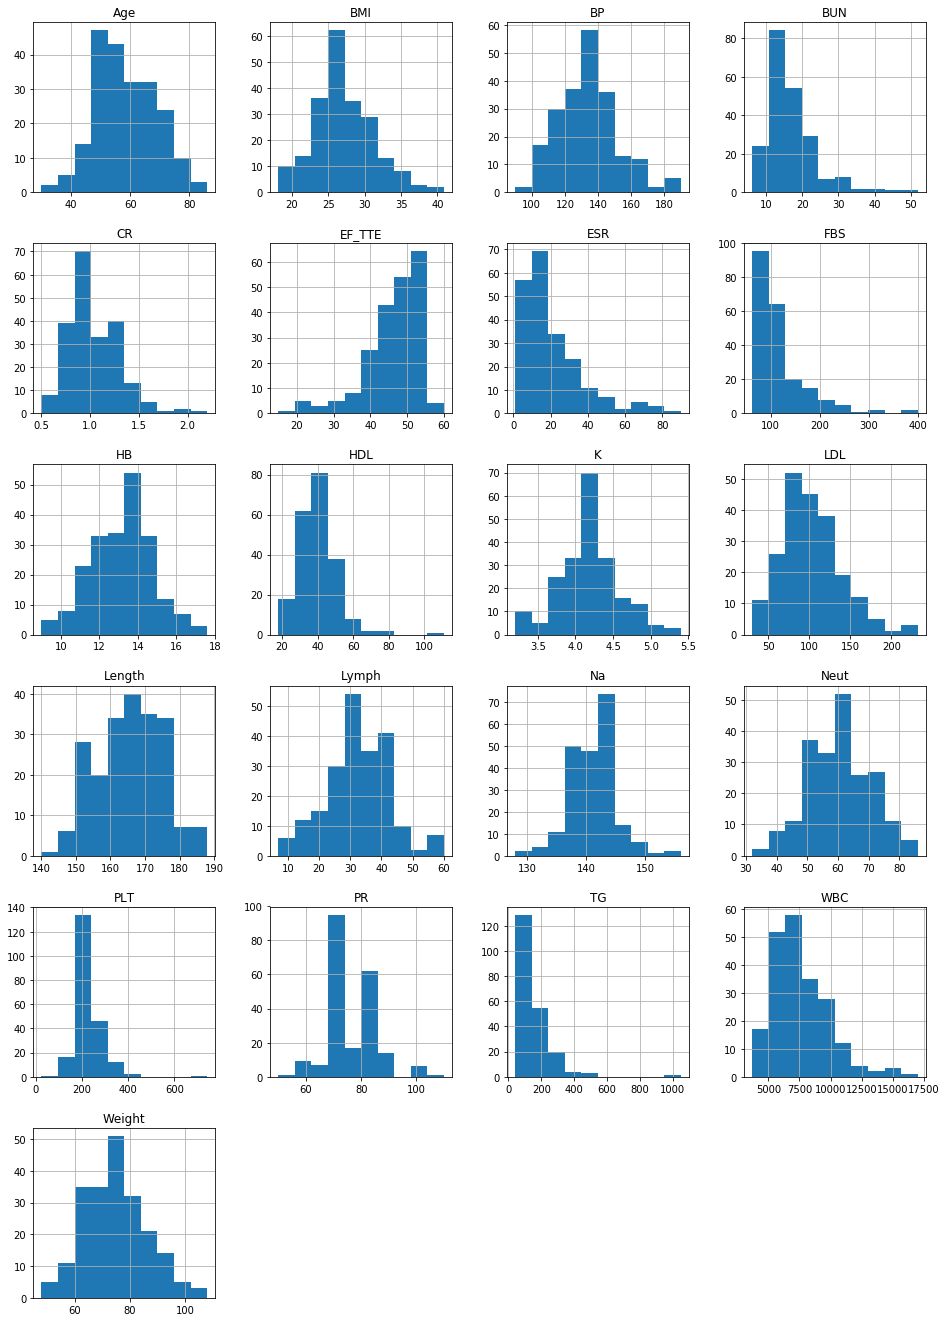

In [25]:
# Histograms for each attribute
x_train_df.hist(layout=(dispRow,dispCol))
pyplot.show()

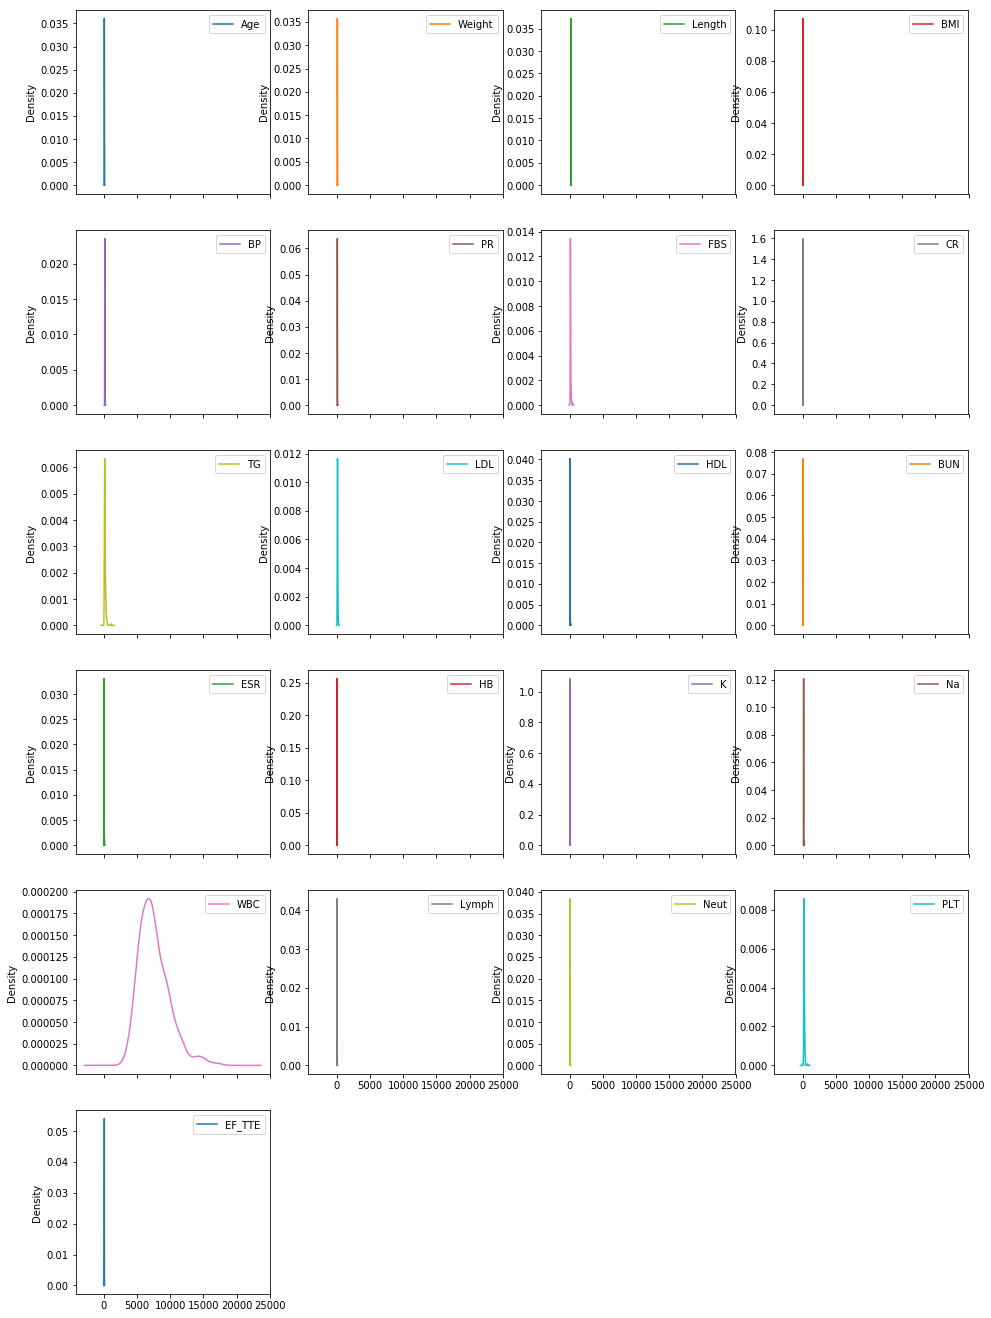

In [26]:
# Density plot for each attribute
x_train_df.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
pyplot.show()

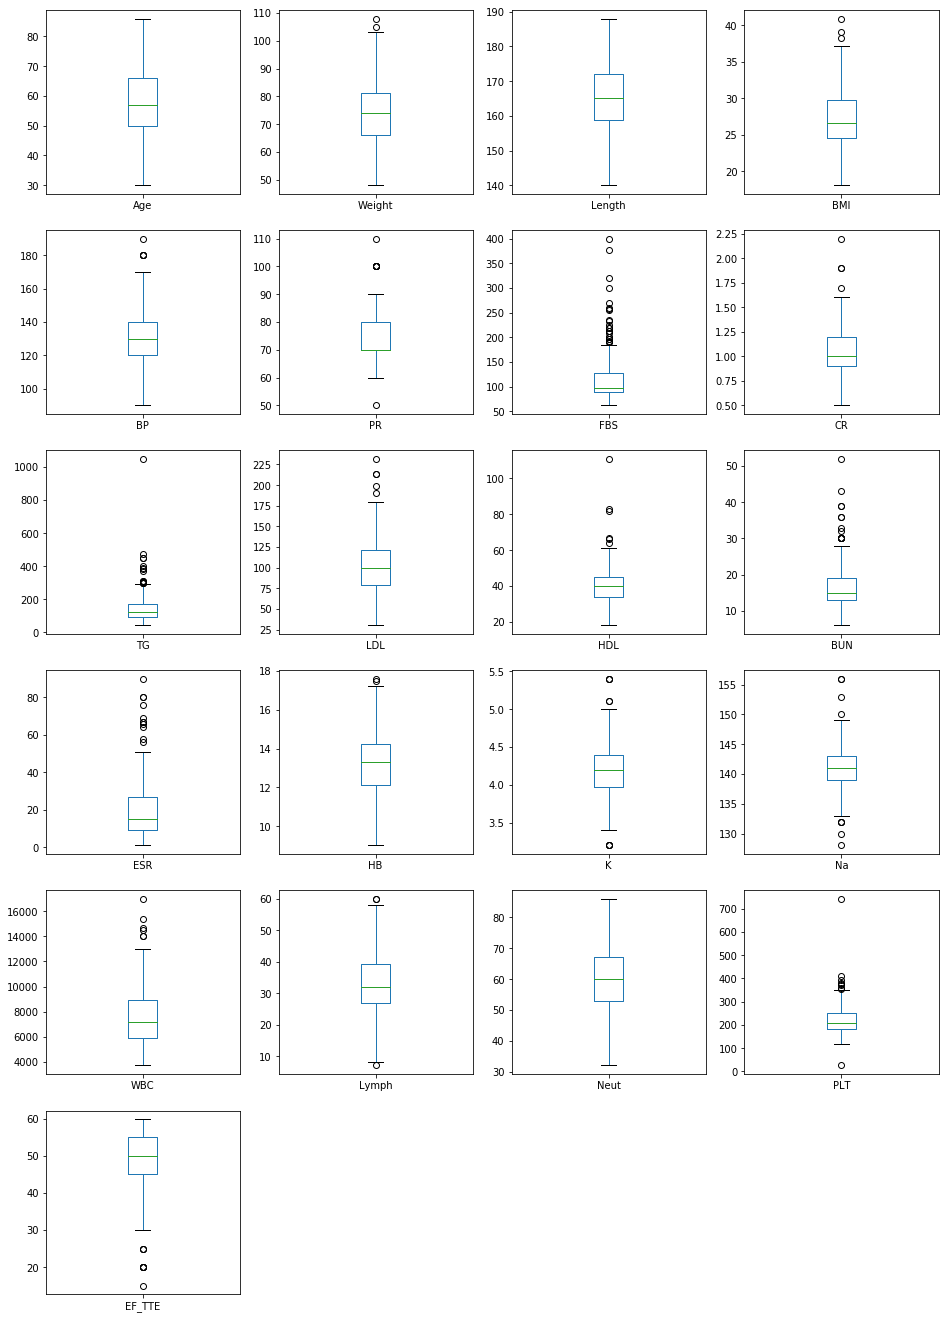

In [27]:
# Box and Whisker plot for each attribute
x_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
pyplot.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [28]:
# Scatterplot matrix
# scatter_matrix(x_train_df)
# pyplot.show()

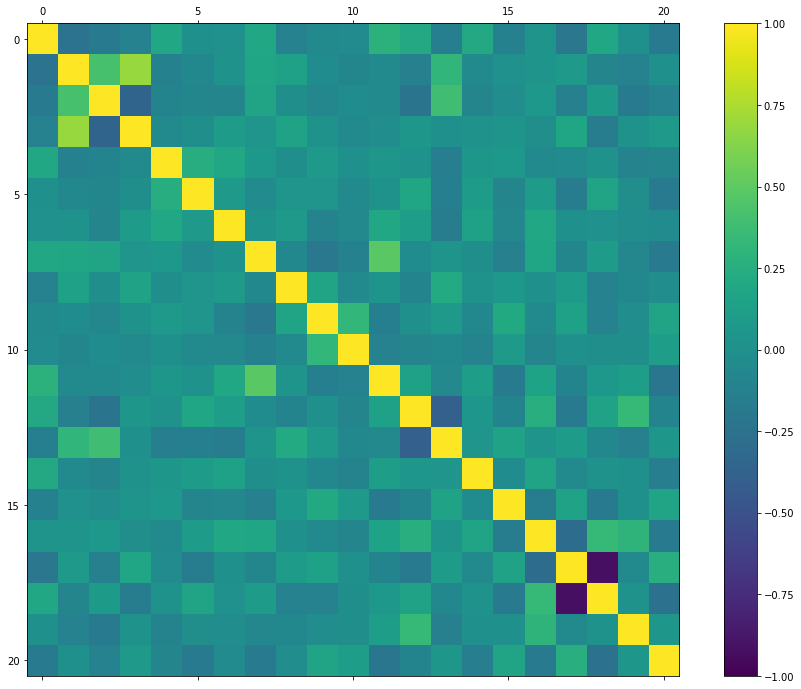

In [29]:
# Correlation matrix
fig = pyplot.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = x_train_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
pyplot.show()

In [30]:
email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [31]:
email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Selection

In [32]:
# Not applicable for this iteration of the project

### 3.b) Data Transforms

In [33]:
# Apply the One-Hot-Encoding (dummy variable handling) technique
x_train_df = get_dummies(x_train_df)
print(x_train_df.dtypes)

Age                       int64
Weight                    int64
Length                    int64
BMI                     float64
BP                        int64
PR                        int64
FBS                       int64
CR                      float64
TG                        int64
LDL                       int64
HDL                     float64
BUN                       int64
ESR                       int64
HB                      float64
K                       float64
Na                        int64
WBC                       int64
Lymph                     int64
Neut                      int64
PLT                       int64
EF_TTE                    int64
Sex_Fmale                 uint8
Sex_Male                  uint8
DM_N                      uint8
DM_Y                      uint8
HTN_N                     uint8
HTN_Y                     uint8
Current_Smoker_N          uint8
Current_Smoker_Y          uint8
EX_Smoker_N               uint8
                         ...   
Atypical

In [34]:
# Apply the One-Hot-Encoding (dummy variable handling) technique
x_test_df = get_dummies(x_test_df)
print(x_test_df.dtypes)

Age                       int64
Weight                    int64
Length                    int64
BMI                     float64
BP                        int64
PR                        int64
FBS                       int64
CR                      float64
TG                        int64
LDL                       int64
HDL                     float64
BUN                       int64
ESR                       int64
HB                      float64
K                       float64
Na                        int64
WBC                       int64
Lymph                     int64
Neut                      int64
PLT                       int64
EF_TTE                    int64
Sex_Fmale                 uint8
Sex_Male                  uint8
DM_N                      uint8
DM_Y                      uint8
HTN_N                     uint8
HTN_Y                     uint8
Current_Smoker_N          uint8
Current_Smoker_Y          uint8
EX_Smoker_N               uint8
                         ...   
Atypical

### 3.c) Display the Final Datasets for Model-Building

In [35]:
# We finalize the training and testing datasets for the modeling activities
x_train = x_train_df.values
y_train = y_train_df.values
x_test = x_test_df.values
y_test = y_test_df.values
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))
email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

x_train.shape: (212, 95) y_train.shape: (212,)
x_test.shape: (91, 95) y_test.shape: (91,)


## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and four ensemble algorithms:

Linear Algorithm: Logistic Regression

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged CART, Random Forest, Extra Trees, and Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [36]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'accuracy'

In [37]:
# Set up Algorithms Spot-Checking Array
models = []
models.append(('LR', LogisticRegression(random_state=seedNum, n_jobs=cpu_num)))
models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
models.append(('KNN', KNeighborsClassifier(n_jobs=cpu_num)))
models.append(('BT', BaggingClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('RF', RandomForestClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('EXT', ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
# models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=cpu_num)))
results = []
names = []
metrics = []

In [38]:
# Generate model in turn
for name, model in models:
	email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startTimeModule))
	email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics))

LR: 0.589394 (0.104982)
Model training time: 0:00:00.126290
CART: 0.585281 (0.087250)
Model training time: 0:00:00.031198
KNN: 0.537446 (0.106497)
Model training time: 0:00:00.031044
BT: 0.650000 (0.138670)
Model training time: 0:00:00.222264
RF: 0.648918 (0.133548)
Model training time: 0:00:00.114502
EXT: 0.617316 (0.108328)
Model training time: 0:00:00.108154
GBM: 0.630736 (0.097649)
Model training time: 0:00:01.143882
Average metrics (accuracy) from all models: 0.6084415584415586


### 4.b) Spot-checking baseline algorithms

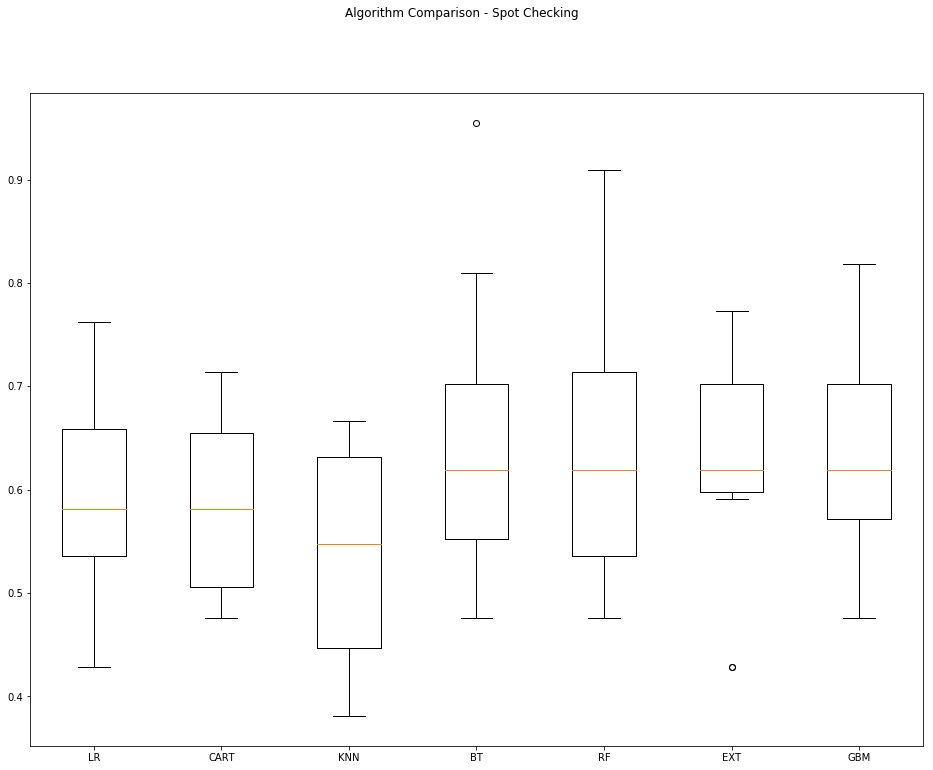

In [39]:
fig = pyplot.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [40]:
# Set up the comparison array
results = []
names = []

In [41]:
# Tuning algorithm #1 - Bagged CART
email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid1 = dict(n_estimators=np.array([50,75,100,125,150]))
model1 = BaggingClassifier(random_state=seedNum, n_jobs=cpu_num)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('BT')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.693396 using {'n_estimators': 50}
0.693396 (0.119970) with: {'n_estimators': 50}
0.693396 (0.123037) with: {'n_estimators': 75}
0.665094 (0.106333) with: {'n_estimators': 100}
0.669811 (0.105236) with: {'n_estimators': 125}
0.674528 (0.097213) with: {'n_estimators': 150}
Model training time: 0:00:11.548739


In [42]:
# Tuning algorithm #2 - Random Forest
email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid2 = dict(n_estimators=np.array([50,75,100,125,150]))
model2 = RandomForestClassifier(random_state=seedNum, n_jobs=cpu_num)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('RF')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.674528 using {'n_estimators': 150}
0.632075 (0.135281) with: {'n_estimators': 50}
0.665094 (0.118976) with: {'n_estimators': 75}
0.650943 (0.130869) with: {'n_estimators': 100}
0.665094 (0.140427) with: {'n_estimators': 125}
0.674528 (0.140833) with: {'n_estimators': 150}
Model training time: 0:00:05.760442


### 5.b) Compare Algorithms After Tuning

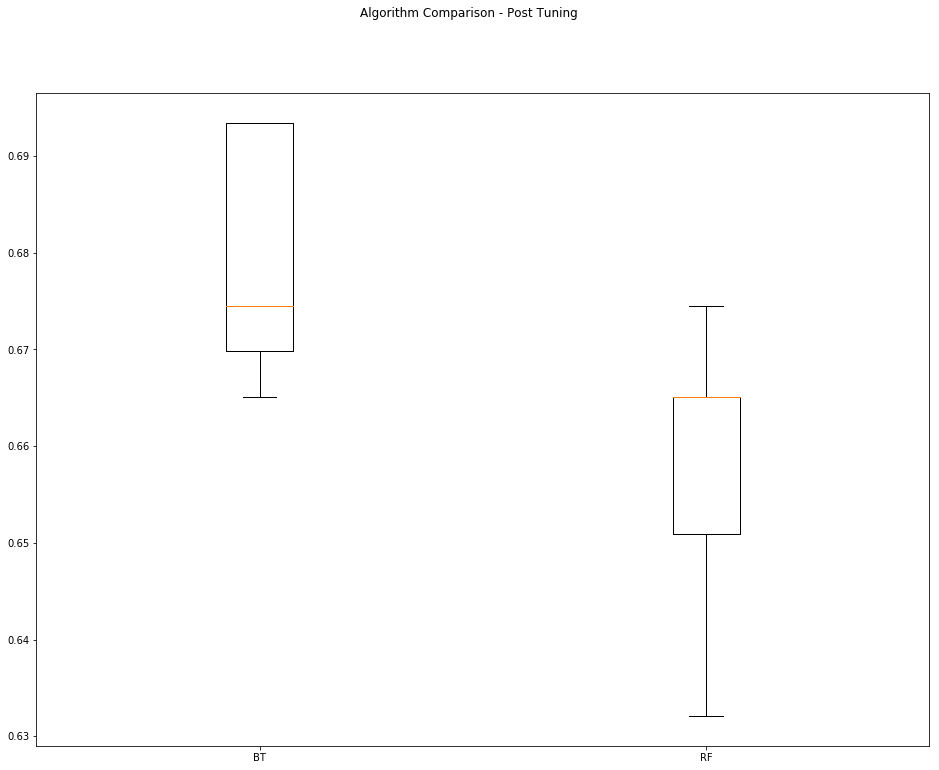

In [43]:
fig = pyplot.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [44]:
email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Predictions on validation dataset

In [45]:
model = BaggingClassifier(n_estimators=50, random_state=seedNum, n_jobs=cpu_num)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.6593406593406593
[[47  9]
 [22 13]]
              precision    recall  f1-score   support

           0       0.68      0.84      0.75        56
           1       0.59      0.37      0.46        35

   micro avg       0.66      0.66      0.66        91
   macro avg       0.64      0.61      0.60        91
weighted avg       0.65      0.66      0.64        91



In [46]:
model = RandomForestClassifier(n_estimators=150, random_state=seedNum, n_jobs=cpu_num)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.6263736263736264
[[48  8]
 [26  9]]
              precision    recall  f1-score   support

           0       0.65      0.86      0.74        56
           1       0.53      0.26      0.35        35

   micro avg       0.63      0.63      0.63        91
   macro avg       0.59      0.56      0.54        91
weighted avg       0.60      0.63      0.59        91



### 6.b) Create standalone model on entire training dataset

In [47]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
x_complete = np.vstack((x_train, x_test))
y_complete = np.concatenate((y_train, y_test))
print("x_complete.shape: {} y_complete.shape: {}".format(x_complete.shape, y_complete.shape))

finalModel = BaggingClassifier(n_estimators=50, random_state=seedNum, n_jobs=cpu_num)
finalModel.fit(x_complete, y_complete)
print ('Model training time:',(datetime.now() - startTimeModule))

x_complete.shape: (303, 95) y_complete.shape: (303,)
Model training time: 0:00:00.161423


### 6.c) Save model for later use

In [48]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

In [49]:
email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:01:18.419601
